# Analysis of categorical inputs for cyclone-induced wave modelling

---
September 7 - 2020 <br>
Orleans, France  <br>
Data based on Rohmer et al. (2016) within the ANR-funded project (ANR – 14 – CE03 – 0013) SPICY http://spicy.brgm.fr/fr

DATA AVAILABILITY: To re-use the present data, please contact Jeremy Rohmer j.rohmer@brgm.fr

# DESCRIPTION
Marine flooding assessment relies on the use of high-resolution hydrodynamic numerical models to understand the relationships between inputs (e.g. offshore sea conditions) and the output variables (e.g. flood spatial extent), and to characterize the uncertainty. The input-output mapping is, however, hindered by two aspects: 1. the high computation time cost of the numerical model limits the number of model runs (usually a few 100s); 2. some of the input variables are often categorical in nature, because different modelling assumptions are equally appropriate. Recent advances in Gaussian Processes with mixed continuous/categorical inputs (Roustant et al., 2018) can bring valuable insights into the influence of such categorical inputs. 

Yet, the problem is that depending on how these categorical variables are modelled (nominal, ordinal) and integrated in the kernel (level-related heteroscedasticity, compound symmetry, group structure and interactions, etc), different viewpoints can be brought. This problem of selecting the most appropriate kernel structure is discussed here. 

The supporting test case is based on the modelling study for cyclone-induced waves at la Reunion Island (Rohmer et al., 2016 within the ANR-funded project SPICY http://spicy.brgm.fr/fr). Calculations are performed using R package *kergp* (https://cran.r-project.org/web/packages/kergp/index.html).

The categorical input corresponds to the index assigned to a cyclone track (denoted *Traj*). Five scalar inputs corresponding to the cyclone chracteristics are taken into account as well (maximum wind speed, distance to the island center, etc.). The variable of interest is the maximum wave height at Sainte Suzanne city located in the NE of the island.

![**Example of cyclone tracks.**](tracks.png)

## Note
  *kergp* was developed within the frame of the Chair in Applied
  Mathematics OQUAIDO, gathering partners in technological research (BRGM,
  CEA, IFPEN, IRSN, Safran, Storengy) and academia (CNRS, Ecole Centrale
  de Lyon, Mines Saint-Etienne, University of Grenoble, University of Nice,
  University of Toulouse) around advanced methods for Computer Experiments.


In [1]:
library(kergp)
library(doFuture)
library(corrplot)
library(ggplot2)
library(GGally)

rm(list=ls())

options(warn=-1)
set.seed(1234)

registerDoFuture()
plan(multisession, workers = max(detectCores()-1, 1))
multistart <- 50


Warning message:
"package 'kergp' was built under R version 3.6.3"Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.6.3"Loading required package: testthat
Loading required package: nloptr
Loading required package: lattice
Warning message:
"package 'doFuture' was built under R version 3.6.3"Loading required package: globals
Loading required package: future
Warning message:
"package 'future' was built under R version 3.6.3"Loading required package: foreach
Warning message:
"package 'foreach' was built under R version 3.6.3"Loading required package: iterators
Loading required package: parallel
corrplot 0.84 loaded
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


# DOE



In [2]:
##INPUTS
X0 <- read.table("./scenarios.txt",header=T)
X <- X0[, 2:6]
X <- scale(X)

##OUTPUT
Y0 <- read.table("./Hs_chemin_correc.txt")
Y <- apply(Y0, 2, max)

df <- data.frame(Traj = as.factor(X0$Traj), 
                 scale(X0[, 2:6]), 
                 Y = Y)
str(df)


'data.frame':	100 obs. of  7 variables:
 $ Traj : Factor w/ 7 levels "1","2","3","4",..: 2 5 6 3 4 5 2 6 5 7 ...
 $ Trans: num  0.368 0.149 -0.696 -1.053 0.745 ...
 $ Vdep : num  0.4299 -0.6877 -0.0105 0.6226 0.0753 ...
 $ Rayo : num  -0.331 0.7 0.791 -0.988 0.156 ...
 $ Vven : num  -0.497 -1.157 1.108 -0.062 -0.257 ...
 $ Pres : num  0.817 0.139 0.683 0.628 0.702 ...
 $ Y    : num  7.35 9.05 11.43 3.41 9.46 ...


    'data.frame':	100 obs. of  7 variables:
     $ Traj : Factor w/ 7 levels "1","2","3","4",..: 2 5 6 3 4 5 2 6 5 7 ...
     $ Trans: num  0.368 0.149 -0.696 -1.053 0.745 ...
     $ Vdep : num  0.4299 -0.6877 -0.0105 0.6226 0.0753 ...
     $ Rayo : num  -0.331 0.7 0.791 -0.988 0.156 ...
     $ Vven : num  -0.497 -1.157 1.108 -0.062 -0.257 ...
     $ Pres : num  0.817 0.139 0.683 0.628 0.702 ...
     $ Y    : num  7.35 9.05 11.43 3.41 9.46 ...
    

## Preliminary plots


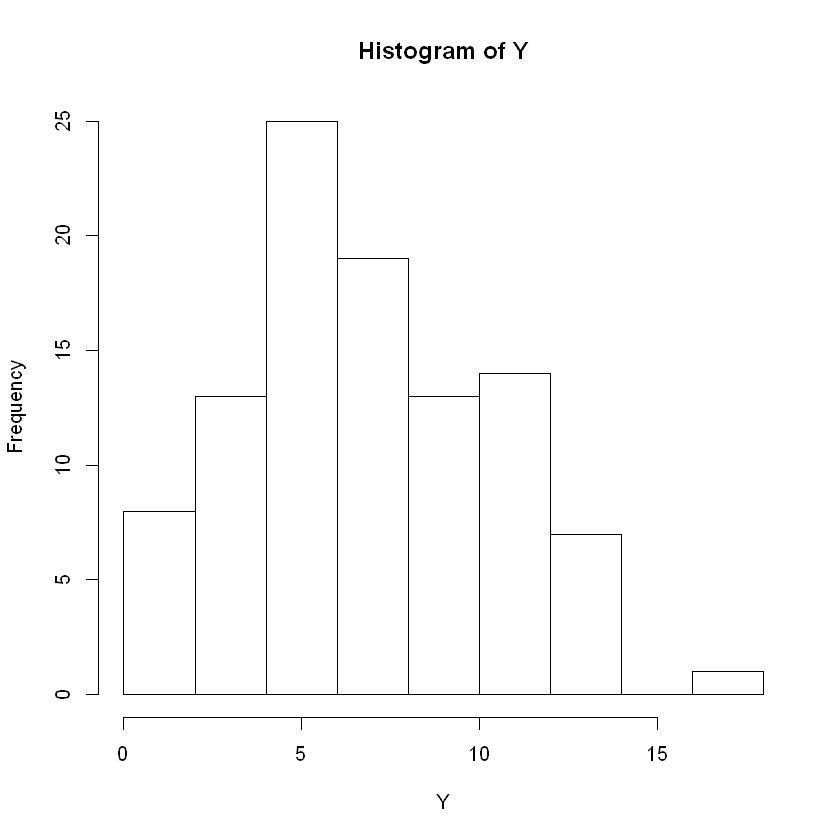

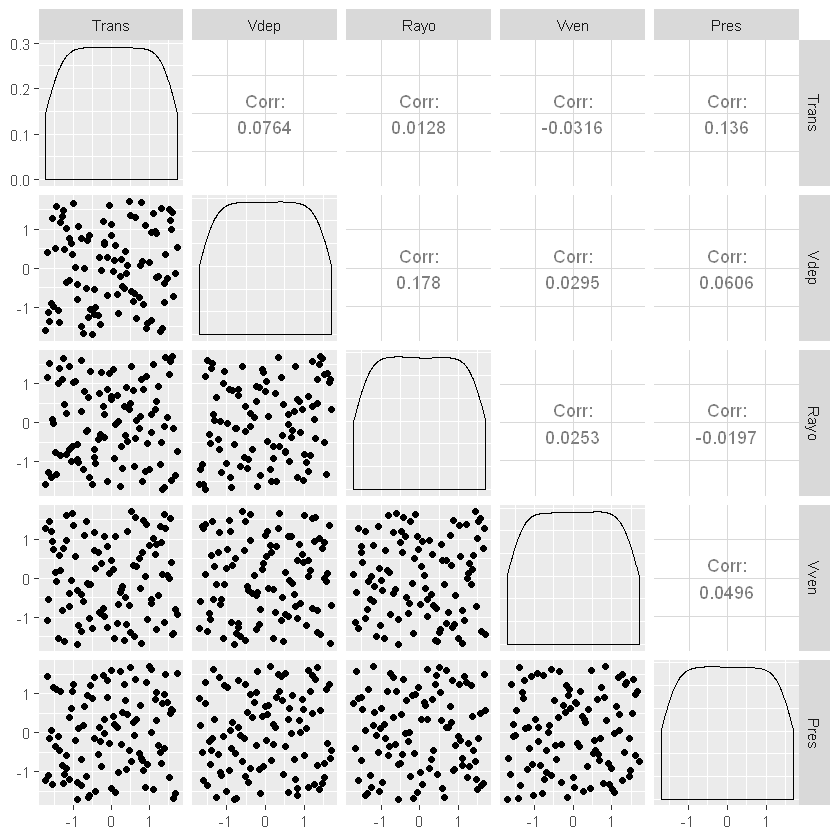

In [3]:
hist(Y)
ggpairs(data.frame(X))


![**Histogram**](output_6_0.png)



![**Pair plot**](output_6_1.png)


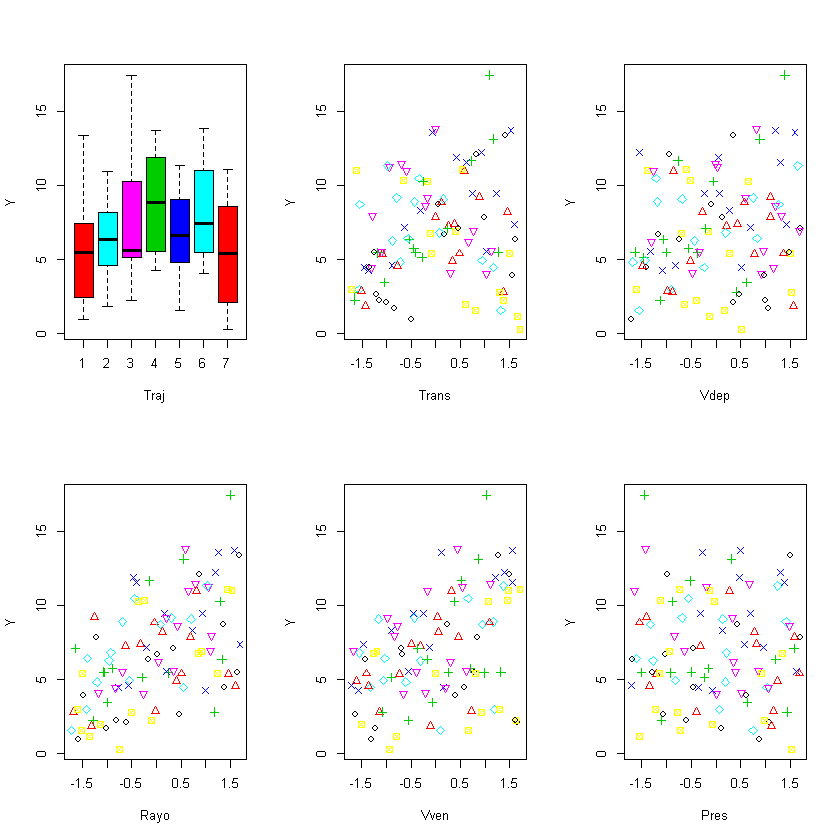

In [4]:
# Ouput versus inputs
# Color & Symbol indicate the level of the categorical input "Traj"
par(mfrow = c(2, 3))
plot(Y ~ ., data = df,
     col = as.integer(df$Traj), pch = as.integer(df$Traj))


![**Scatter plot**](output_7_0.png)


### Conditional plots ("treillis" or "facets")


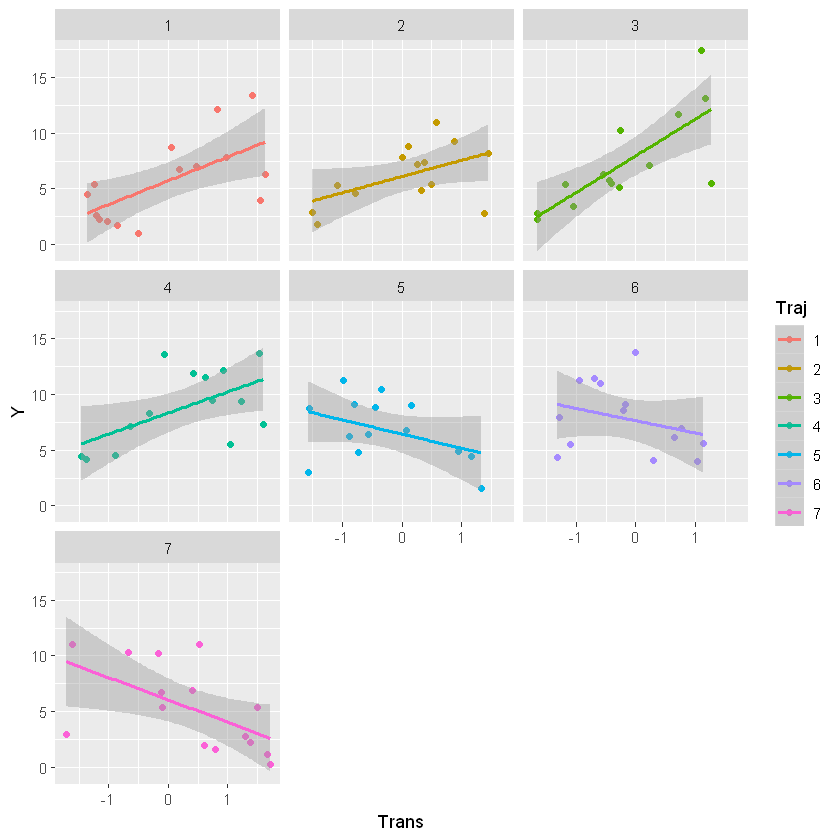

In [5]:
library(ggplot2) 
ggplot(data = df, aes(x = Trans, y = Y, col = Traj)) + geom_point() + 
facet_wrap(~ Traj) + geom_smooth(method = "lm")
# Y versus Trans does not have the same slope depending on the levels of Traj.
# This indicate a second-order interaction between Trans and Traj on Y.


    `geom_smooth()` using formula 'y ~ x'
    
    


![**Treillis**](output_9_1.png)


## Linear modelling



Call:
lm(formula = Y ~ . + Trans * Traj, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6209 -1.2816  0.0399  1.4520  3.9741 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.40000    0.50070  10.785  < 2e-16 ***
Traj2        0.99052    0.72851   1.360 0.177669    
Traj3        2.39035    0.73492   3.253 0.001662 ** 
Traj4        2.57064    0.73848   3.481 0.000803 ***
Traj5        2.48867    0.76178   3.267 0.001589 ** 
Traj6        1.92985    0.73464   2.627 0.010280 *  
Traj7        0.39077    0.73892   0.529 0.598343    
Trans        2.41204    0.46777   5.156 1.71e-06 ***
Vdep         0.42398    0.21395   1.982 0.050863 .  
Rayo         1.76061    0.20956   8.402 1.12e-12 ***
Vven         1.14484    0.21608   5.298 9.65e-07 ***
Pres        -0.42376    0.20584  -2.059 0.042703 *  
Traj2:Trans -0.25887    0.73443  -0.352 0.725387    
Traj3:Trans  0.08308    0.72425   0.115 0.908950    
Traj4:Trans -1.58208    0.70971  -2.229 0.0

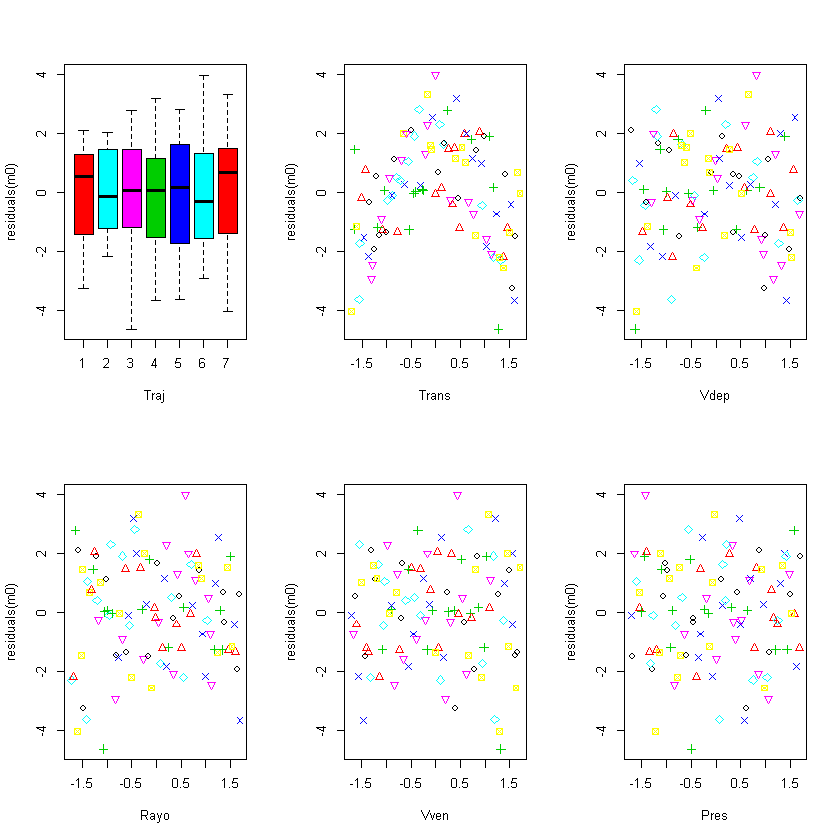

In [6]:
# A first linear model with all variables and the interaction Trans * Traj
m0 <- lm(Y ~ . + Trans * Traj, data = df)
summary(m0)
par(mfrow = c(2, 3))
plot(residuals(m0) ~ ., data = df[, -7], 
     col = as.integer(df$Traj), pch = as.integer(df$Traj))
# Residuals show large quadratic effect for variable Trans


    
    Call:
    lm(formula = Y ~ . + Trans * Traj, data = df)
    
    Residuals:
        Min      1Q  Median      3Q     Max 
    -4.6209 -1.2816  0.0399  1.4520  3.9741 
    
    Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
    (Intercept)  5.40000    0.50070  10.785  < 2e-16 ***
    Traj2        0.99052    0.72851   1.360 0.177669    
    Traj3        2.39035    0.73492   3.253 0.001662 ** 
    Traj4        2.57064    0.73848   3.481 0.000803 ***
    Traj5        2.48867    0.76178   3.267 0.001589 ** 
    Traj6        1.92985    0.73464   2.627 0.010280 *  
    Traj7        0.39077    0.73892   0.529 0.598343    
    Trans        2.41204    0.46777   5.156 1.71e-06 ***
    Vdep         0.42398    0.21395   1.982 0.050863 .  
    Rayo         1.76061    0.20956   8.402 1.12e-12 ***
    Vven         1.14484    0.21608   5.298 9.65e-07 ***
    Pres        -0.42376    0.20584  -2.059 0.042703 *  
    Traj2:Trans -0.25887    0.73443  -0.352 0.725387    
    Traj3:Trans  0.08308    0.72425   0.115 0.908950    
    Traj4:Trans -1.58208    0.70971  -2.229 0.028537 *  
    Traj5:Trans -2.54946    0.76152  -3.348 0.001232 ** 
    Traj6:Trans -3.30527    0.78344  -4.219 6.29e-05 ***
    Traj7:Trans -3.97270    0.68137  -5.830 1.05e-07 ***
    ---
    Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
    
    Residual standard error: 1.933 on 82 degrees of freedom
    Multiple R-squared:  0.7565,	Adjusted R-squared:  0.7061 
    F-statistic: 14.99 on 17 and 82 DF,  p-value: < 2.2e-16
    



![**Linear regression analysis**](output_11_1.png)



Call:
lm(formula = Y ~ . + I(Trans^2) + Trans * Traj, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.13754 -1.10323 -0.06629  0.98416  3.14541 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.9623     0.4255  16.364  < 2e-16 ***
Traj2         0.6554     0.5508   1.190 0.237550    
Traj3         2.0370     0.5558   3.665 0.000440 ***
Traj4         2.4833     0.5568   4.460 2.61e-05 ***
Traj5         2.1207     0.5761   3.681 0.000417 ***
Traj6         1.3070     0.5593   2.337 0.021922 *  
Traj7         0.4396     0.5571   0.789 0.432293    
Trans         2.6827     0.3543   7.573 5.19e-11 ***
Vdep          0.4819     0.1614   2.985 0.003752 ** 
Rayo          1.7021     0.1581  10.763  < 2e-16 ***
Vven          1.2552     0.1635   7.678 3.23e-11 ***
Pres         -0.5191     0.1556  -3.335 0.001287 ** 
I(Trans^2)   -1.3763     0.1730  -7.956 9.18e-12 ***
Traj2:Trans  -0.7929     0.5577  -1.422 0.158963    
Traj3:Trans  -0.6827

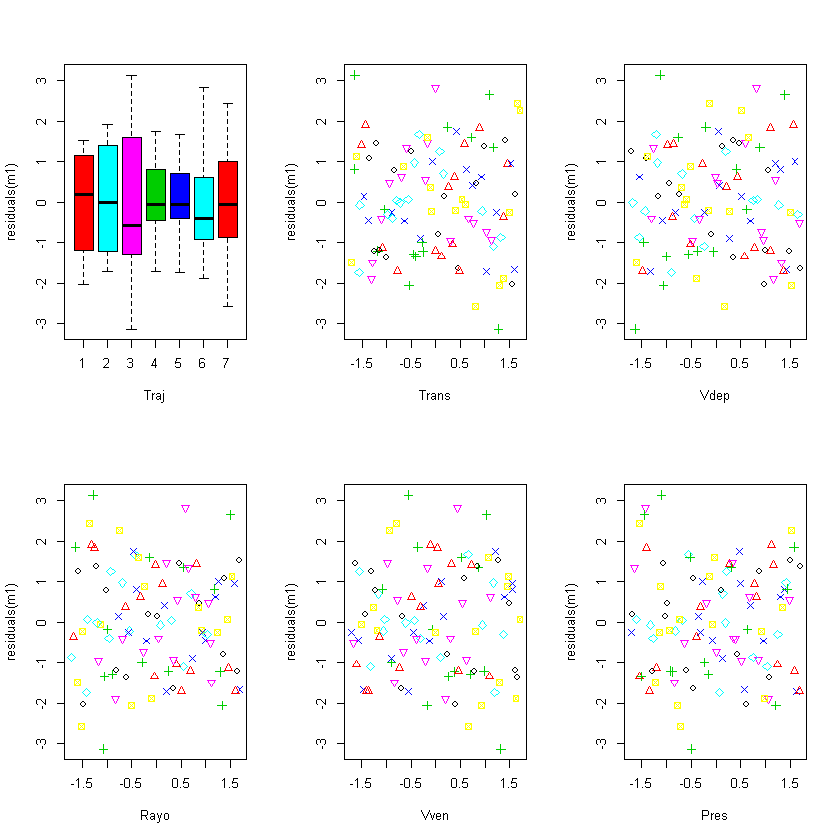

In [7]:
# We add the quadratic effect to the model
m1 <- lm(Y ~ . + I(Trans^2) + Trans * Traj, data = df)
summary(m1)
par(mfrow = c(2, 3))
plot(residuals(m1) ~ ., data = df[, -7], 
     col = as.integer(df$Traj), pch = as.integer(df$Traj))
# much better


    
    Call:
    lm(formula = Y ~ . + I(Trans^2) + Trans * Traj, data = df)
    
    Residuals:
         Min       1Q   Median       3Q      Max 
    -3.13754 -1.10323 -0.06629  0.98416  3.14541 
    
    Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
    (Intercept)   6.9623     0.4255  16.364  < 2e-16 ***
    Traj2         0.6554     0.5508   1.190 0.237550    
    Traj3         2.0370     0.5558   3.665 0.000440 ***
    Traj4         2.4833     0.5568   4.460 2.61e-05 ***
    Traj5         2.1207     0.5761   3.681 0.000417 ***
    Traj6         1.3070     0.5593   2.337 0.021922 *  
    Traj7         0.4396     0.5571   0.789 0.432293    
    Trans         2.6827     0.3543   7.573 5.19e-11 ***
    Vdep          0.4819     0.1614   2.985 0.003752 ** 
    Rayo          1.7021     0.1581  10.763  < 2e-16 ***
    Vven          1.2552     0.1635   7.678 3.23e-11 ***
    Pres         -0.5191     0.1556  -3.335 0.001287 ** 
    I(Trans^2)   -1.3763     0.1730  -7.956 9.18e-12 ***
    Traj2:Trans  -0.7929     0.5577  -1.422 0.158963    
    Traj3:Trans  -0.6827     0.5544  -1.231 0.221749    
    Traj4:Trans  -1.6609     0.5351  -3.104 0.002631 ** 
    Traj5:Trans  -2.9266     0.5760  -5.081 2.37e-06 ***
    Traj6:Trans  -3.8717     0.5949  -6.508 5.89e-09 ***
    Traj7:Trans  -4.0529     0.5137  -7.889 1.24e-11 ***
    ---
    Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
    
    Residual standard error: 1.457 on 81 degrees of freedom
    Multiple R-squared:  0.8633,	Adjusted R-squared:  0.833 
    F-statistic: 28.43 on 18 and 81 DF,  p-value: < 2.2e-16
    



![**Linear regression analysis 2**](output_12_1.png)


# KERNEL DEFINITION


In [8]:
L <- 7 ## number of levels
d <- 5 ## number of continuous inputs



### CONTINUOUS INPUTS


In [9]:
#### CONTINUOUS INPUTS
kCont1 <- covRadial(k1Fun1 = k1Fun1Matern5_2, 
                    d = d, cov = "homo", inputs = colnames(X))


Below, we set-up different parametrisations of the kernels for the categorical input, namely:
1. *Categorical*: we assume no additional information and use the most general version of the categorical kernel;
2. *Ordinal*: we assume that the categorical input can be assimilated to an ordinal variable;
3. *Low rank*: we assume that there is a latent continuous variable that represents the effect of the categorical variable;
4. *Group*: we define some groups among the levels based on expert information.


### ORDINAL


In [10]:
u <- ordered(df$Traj, labels = letters[1:L])
kOrd <- covOrd(ordered = u, warpFun = "spline2", inputs = "Traj", cov = "corr")
kmixO <- covComp(formula = ~ kCont1() * kOrd() )



### LOW RANK 3 groups


In [11]:
kcatLR3 <- q1LowRank(factor = df$Traj, rank = 3, input = "Traj", cov = "corr")
kmixLR3 <- covComp(formula = ~ kCont1() * kcatLR3())



### LOW RANK 2 groups


In [12]:
kcatLR2 <- q1LowRank(factor = df$Traj, rank = 2, input = "Traj", cov = "corr")
kmixLR2 <- covComp(formula = ~ kCont1() * kcatLR2())



### CATEGORICAL (One group)


In [13]:
kcat1 <- q1CompSymm(df$Traj, input = "Traj", cov = "corr")
kmixC1 <- covComp(formula = ~ kCont1() * kcat1() )



### CATEGORICAL - TWO GROUPS


In [14]:
my2GroupList <- list(A = 1:4, B = 5:7)
kcat2 <- covQualNested(input = "Traj", groupList = my2GroupList,
                       between = "Symm", within = "Diag",
                       covBet = "homo", covWith = "corr")
kmixC2 <- covComp(formula = ~ kCont1() * kcat2())



### CATEGORICAL - TWO GROUPS - Compound Symmetric


In [15]:
kcat2S <- covQualNested(input = "Traj", groupList = my2GroupList,
                       between = "CompSymm", within = "Diag",
                       covBet = "homo", covWith = "corr")
kmixC2S <- covComp(formula = ~ kCont1() * kcat2S())



### CATEGORICAL - THREE GROUPS


In [16]:
my3GroupList <- list(A = c(1, 2), B = c(3, 4, 5), C = c(6, 7))
kcat3 <- covQualNested(input = "Traj", groupList = my3GroupList,
                       between = "Symm", within = "Diag",
                       covBet = "homo", covWith = "corr")
kmixC3 <- covComp(formula = ~ kCont1() * kcat3())



#### CATEGORICAL - THREE GROUPS  - Compound Symmetric


In [17]:
kcat3S <- covQualNested(input = "Traj", groupList = my3GroupList,
                       between = "CompSymm", within = "Diag",
                       covBet = "homo", covWith = "corr")
kmixC3S <- covComp(formula = ~ kCont1() * kcat3S())


# GP fitting

### No assumption


In [18]:
compGrad <- TRUE
fitList <- list()



### One group


In [19]:
#df$Traj<-as.integer(df$Traj)

fitC1 <- gp(formula = Y ~ 1, cov = kmixC1, data = df,
            multistart = multistart, compGrad = compGrad)


In [20]:
fitList[["group1"]] <- fitC1



## Groups
### Two groups


In [21]:
fitC2 <- gp(formula = Y ~ 1, cov = kmixC2, data = df,
            multistart = multistart, compGrad = compGrad)



### Two groups - CompSymm


In [22]:
fitC2S <- gp(formula = Y ~ 1, cov = kmixC2S, data = df,
            multistart = multistart, compGrad = compGrad)


### Three groups


In [23]:
fitC3 <- gp(formula = Y ~ 1, cov = kmixC3, data = df,
            multistart = multistart, compGrad = compGrad)


### Three groups - CompSymm


In [24]:
fitC3S <- gp(formula = Y ~ 1, cov = kmixC3S, data = df,
            multistart = multistart, compGrad = compGrad)


In [25]:
fitList[["groups2"]] <- fitC2
fitList[["groups3"]] <- fitC3
fitList[["groups2S"]] <- fitC2S
fitList[["groups3S"]] <- fitC3S



## Low rank


In [26]:
## Low rank
fitLR2 <- gp(formula = Y ~ 1, cov = kmixLR2, data = df,
            multistart = multistart, compGrad = compGrad)

fitLR3 <- gp(formula = Y ~ 1, cov = kmixLR3, data = df,
            multistart = multistart, compGrad = compGrad)


In [27]:
fitList[["Low-Rank-2"]] <- fitLR2
fitList[["Low-Rank-3"]] <- fitLR3


## Ordinal



In [28]:
## Ordinal
dfO <- data.frame(as.matrix(X0[,2:6]), u, as.numeric(Y))
names(dfO)[ncol(df)] <- "Y"
names(dfO)[ncol(df)-1] <- "Traj"

fitO <- gp(formula = Y ~ 1, cov = kmixO, data = dfO,
            multistart = multistart, compGrad = compGrad)


In [29]:
fitList[["Ordinal"]] <- fitO



# Correlation matrix analysis



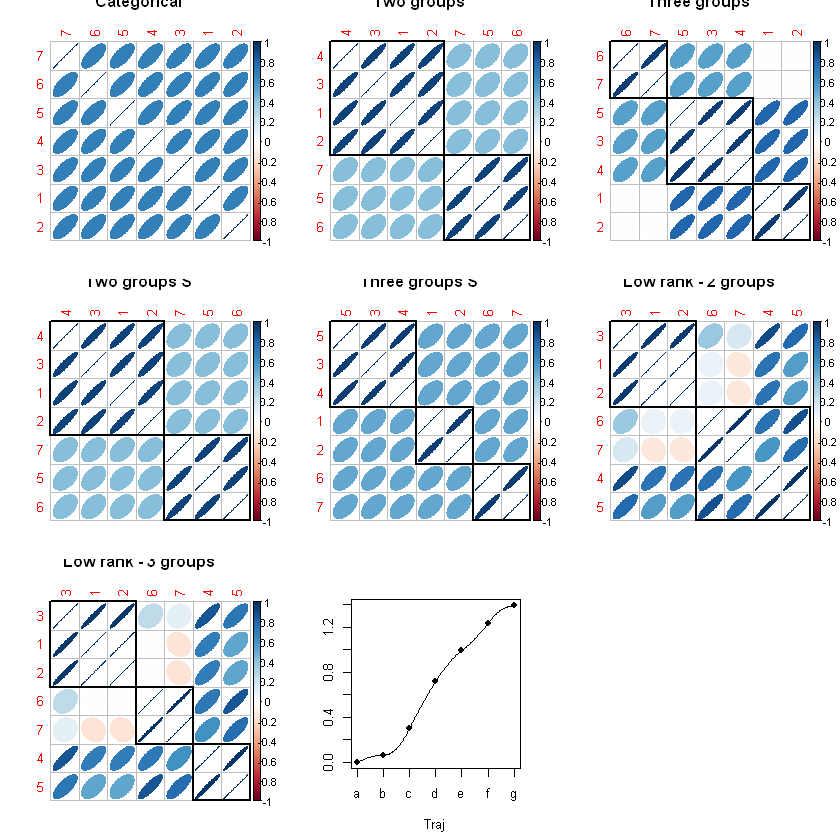

In [31]:
par(mfrow=c(3,3), mar = c(4, 4, 2, 2) + 0.5)
plot(as.list(fitC1$covariance)$kcat1, type = "cor", method = "ellipse", order = "hclust", main = "Categorical")
plot(as.list(fitC2$covariance)$kcat2, type = "cor", addrect = 2, method = "ellipse", order = "hclust", main = "Two groups")
plot(as.list(fitC3$covariance)$kcat3, type = "cor", addrect = 3, method = "ellipse", order = "hclust", main = "Three groups")
plot(as.list(fitC2S$covariance)$kcat2S, type = "cor", addrect = 2, method = "ellipse", order = "hclust", main = "Two groups S")
plot(as.list(fitC3S$covariance)$kcat3S, type = "cor", addrect = 3, method = "ellipse", order = "hclust", main = "Three groups S")
plot(as.list(fitLR2$covariance)$kcatLR2, type = "cor", addrect = 2, method = "ellipse",order = "hclust", main = "Low rank - 2 groups")
plot(as.list(fitLR3$covariance)$kcatLR3, type = "cor", addrect = 3, method = "ellipse",order = "hclust", main = "Low rank - 3 groups")
plot(as.list(fitO$covariance)$kOrd, type = "warp") ## warping function


![**Correlation matrix analysis**](output_32_0.png)


# Model selection
Let us consider $\Theta^*$ the MLE-based estimates of the vector of $N_p$ kernel parameters (hyperparameters), $\textbf{D}$ the training dataset (with $N_s$ observations), and $L$ the likelihood function.

We aim at selecting the "best" kernel models (most appropriate) with respect to four criteria:

1. Akaike Information criterion AIC (Akaike 1974) defined as $-2log(L(\Theta^*|\textbf{D}))+2N_p$;

2. Bayesian Information criterion BIC (Schwarz 1978) defined as $-2log(L(\Theta^*|\textbf{D}))+2N_plog(N_s)$;

3. Minimum description length MDL (e.g., Hoeting et al., 2006) defined as $1/2(-2log(L(\Theta^*|\textbf{D}))+log(N_s)*(N_p+1))$;

4. One minus the coefficient of determination derived from a leave-one-out cross validation $1-Q^2_{cv}$.

The most appropriate structure is identified for the minimum criterion values.


In [32]:
myAIC <- function(L, k){
        # L: log-likelihood, k: number of para
        -2*L+2*k
        }
myBIC <- function(L, k,n){
        # L: log-likelihood, k: number of para, n: number of obs
        -2*L+log(n)*k
        }
myMDL<- function(L, k,n){
        # L: log-likelihood, k: number of para, n: number of obs
        1/2*(-2*L+log(n)*(k+1))
        }

Q2 <- function(obs, pred){
        1 - sum( (pred - obs) ^ 2 ) / sum( (mean(obs) - obs) ^ 2 )
        }


## INFORMATION CRITERIA



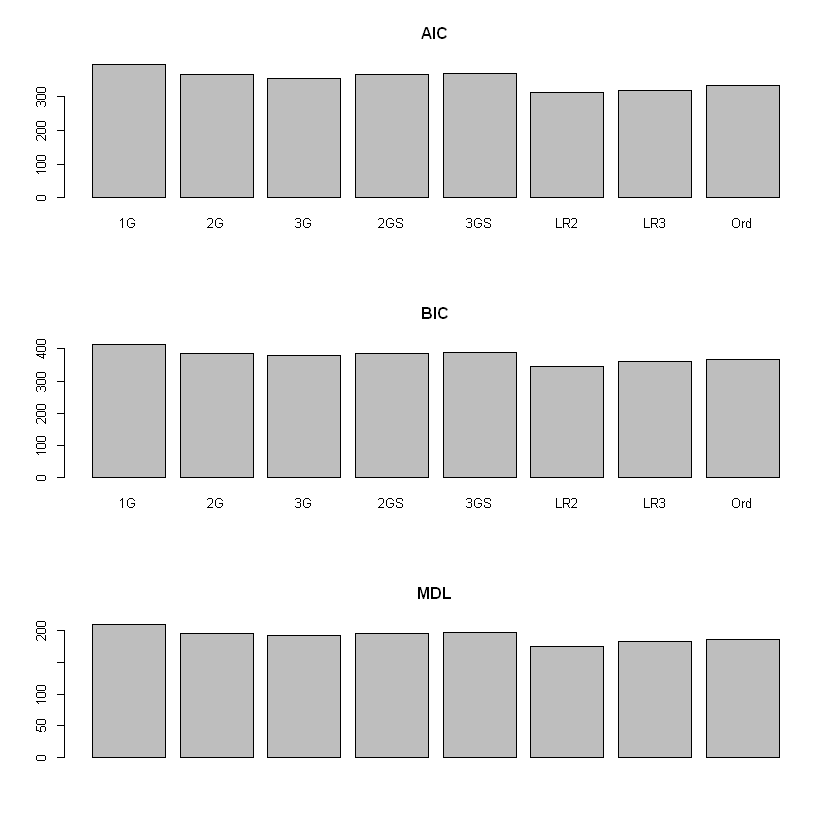

In [33]:
nModel <- length(fitList)
shortModelNames <- c("1G", "2G", "3G", "2GS", "3GS", "LR2", "LR3", "Ord")
fitAIC <- fitBIC <- fitMDL <- rep(NA, nModel)
n <- nrow(df)

for (i in 1:nModel){
    nParam <- length(coef(fitList[[i]]$covariance))
    fitAIC[i] <- myAIC(fitList[[i]]$logLik, k = nParam) 
    fitBIC[i] <- myBIC(fitList[[i]]$logLik, k = nParam, n = n)
    fitMDL[i] <- myMDL(fitList[[i]]$logLik, k = nParam, n = n)
}
names(fitAIC) <- names(fitBIC) <- shortModelNames
par(mfrow = c(3, 1))
barplot(fitAIC, main = "AIC")
barplot(fitBIC, main = "BIC")
barplot(fitMDL, main = "MDL")
par(mfrow = c(1, 1))


![Information criteria](output_36_0.png)


## Q2cv


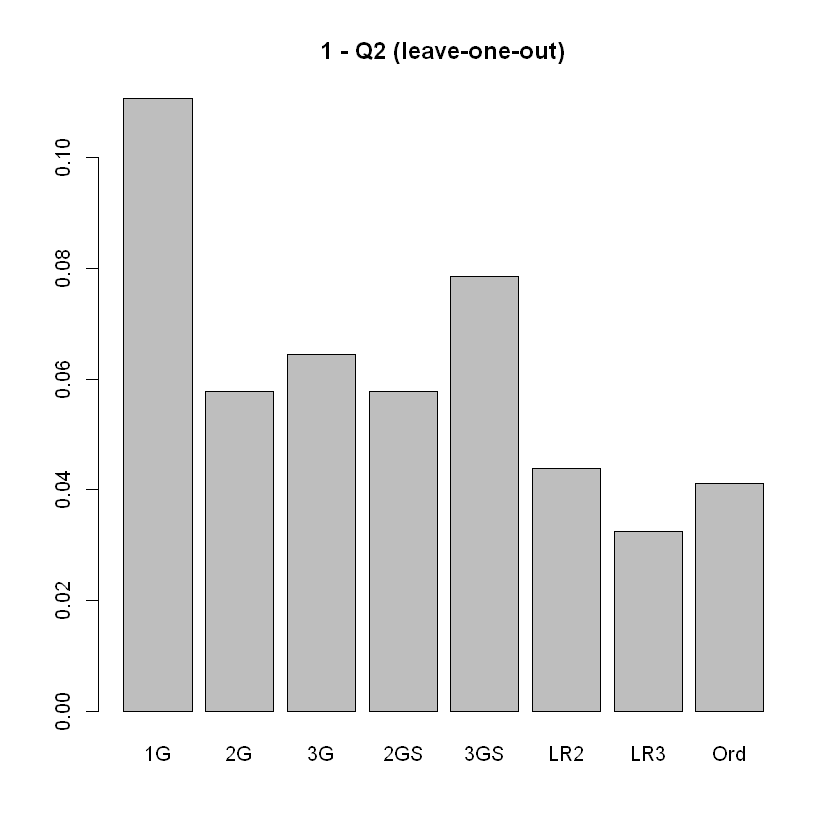

In [34]:
fitQ2CV <- rep(NA, nModel)
names(fitQ2CV) <- shortModelNames

for (i in 1:nModel){
    LOO <- influence(fitList[[i]])$mean
    fitQ2CV[i] <- Q2(Y, LOO)
}

barplot(1 - fitQ2CV, main = "1 - Q2 (leave-one-out)")


![LOOCV](output_38_0.png)


## Validation plot


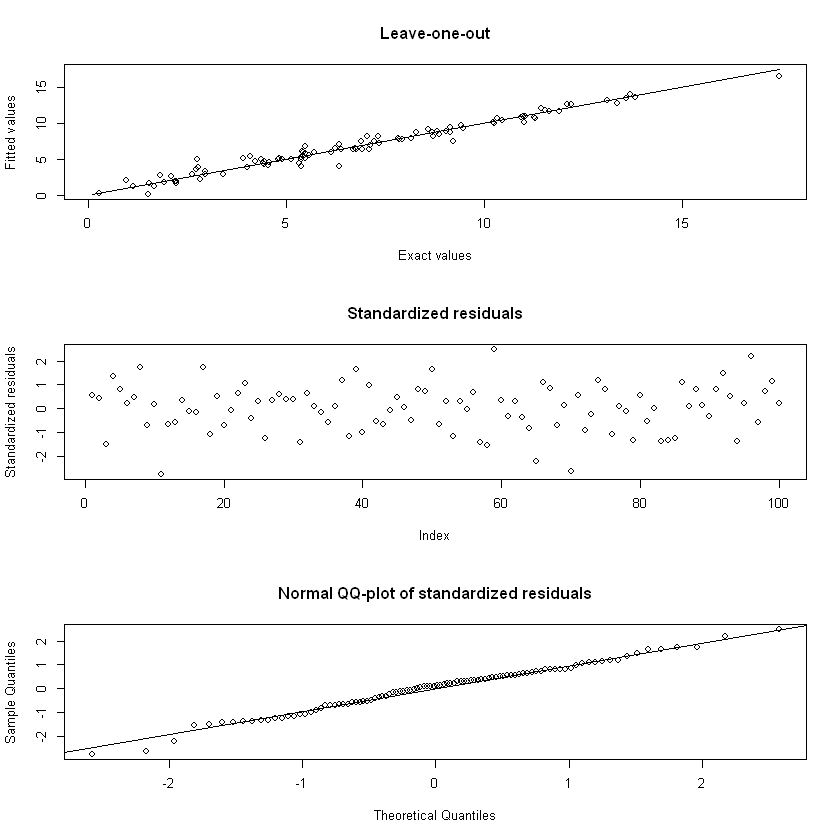

In [37]:
plot(fitList[["Low-Rank-3"]])



![png](output_40_0.png)


# References

  1. Rohmer J., Lecacheux S., Pedreros R., Quetelard H., Bonnardot F., and Idier D. (2016).
  "Dynamic parameter sensitivity in numerical modelling of cyclone-induced waves: a multi-look approach using advanced meta-modelling techniques".
  *Natural Hazards*,  84, 1765–1792
  [[link]](https://link.springer.com/article/10.1007/s11069-016-2513-8)
  
  2. Roustant, O., Padonou, E., Deville, Y., Clément, A., Perrin, G., Giorla, J., & Wynn, H. (2018). 
  "Group kernels for Gaussian process metamodels with categorical inputs". 
  arXiv preprint 
  [[link]](https://arxiv.org/abs/1802.02368).
  
  3. Akaike, H. (1974). 
  "A new look at the statistical model identification".
  *IEEE transactions on automatic control*, 19(6), 716-723.
  
  4. Schwarz, G.E. (1978).
  "Estimating the dimension of a model".
  *Annals of Statistics*, 6(2), 461–464.
  
  5. Hoeting, J. A., Davis, R. A., Merton, A. A., & Thompson, S. E. (2006).
  "Model selection for geostatistical models". 
  *Ecological Applications*, 16(1), 87-98.
